# ATMS 523: Template solution to Module 2 homework

Adapted from: https://nbviewer.org/github/awslabs/amazon-asdi/blob/main/examples/dask/notebooks/era5_zarr.ipynb

In [1]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report, Client, progress


In [2]:
from dask.distributed import Client, progress

In [3]:
client = Client(dashboard_address=':5555')  # set up local cluster on your laptop
client

2022-09-20 12:00:53,951 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/fg/4q4dm1rn35s3pxqynw1p5n4h0000gn/T/dask-worker-space/worker-m4xisgb7', purging
2022-09-20 12:00:53,952 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/fg/4q4dm1rn35s3pxqynw1p5n4h0000gn/T/dask-worker-space/worker-40po8fzu', purging
2022-09-20 12:00:53,952 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/fg/4q4dm1rn35s3pxqynw1p5n4h0000gn/T/dask-worker-space/worker-qqa1zaze', purging
2022-09-20 12:00:53,952 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/fg/4q4dm1rn35s3pxqynw1p5n4h0000gn/T/dask-worker-space/worker-hi2ddr2f', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:5555/status,
Dashboard: http://127.0.0.1:5555/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58577,Workers: 4
Dashboard: http://127.0.0.1:5555/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58606,Total threads: 2
Dashboard: http://127.0.0.1:58608/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58583,


In [4]:
# Make garbage collection explicit to prevent deadlocks
import gc
from distributed import WorkerPlugin

class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()             

    def transition(self, key, start, finish, *args, **kwargs):
       if finish == 'executing':
          self.worker._throttled_gc.collect()
          if gc.isenabled():
             gc.disable()

plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:58600': {'status': 'OK'},
 'tcp://127.0.0.1:58601': {'status': 'OK'},
 'tcp://127.0.0.1:58606': {'status': 'OK'},
 'tcp://127.0.0.1:58607': {'status': 'OK'}}

In [5]:
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        # Get files
        files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out

In [6]:
%%time

ds = open_era5_range(1979, 2021, ["precipitation_amount_1hour_Accumulation"])

precipitation_amount_1hour_Accumulation
CPU times: user 2.89 s, sys: 401 ms, total: 3.29 s
Wall time: 29.5 s


In [7]:
ds

,Array,Chunk
Bytes,1.42 TiB,31.93 MiB
Shape,"(376937, 721, 1440)","(372, 150, 150)"
Count,1033 Graph Layers,51600 Chunks
Type,float32,numpy.ndarray


Compute the monthly climatology of precipitation rate.

In [103]:
#set site
lat_cmi = 40.1
lon_cmi = -88.0

In [ ]:
monthly_climatology = ds["precipitation_amount_1hour_Accumulation"].sel(lat=lat_cmi,lon=360.+lon_cmi,method='nearest').groupby('valid_time_end_utc.month').mean().compute()

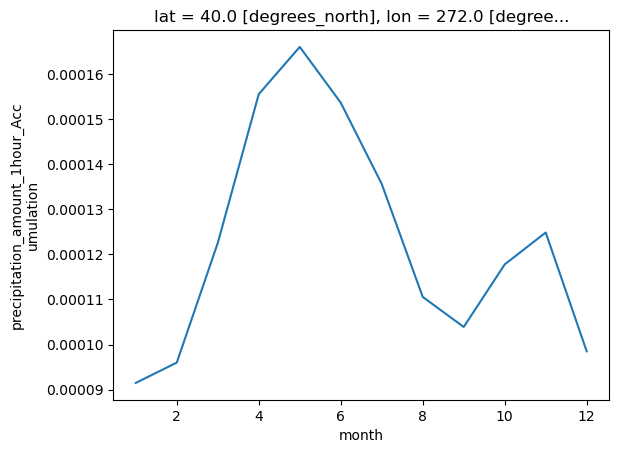

In [9]:
monthly_climatology.plot()

We'll do April - June for the wettest period.  Now compute the 95th percentile of wet days during these months.

In [10]:
#within the wettest 3 month period, find the days that exceed the 95th percentile


champaign_hourly = ds["precipitation_amount_1hour_Accumulation"].sel(lat=lat_cmi,lon=360.+lon_cmi,method='nearest')

In [11]:
champaign_hourly_wet = champaign_hourly[(champaign_hourly.valid_time_end_utc.dt.month >= 4) & ((champaign_hourly.valid_time_end_utc.dt.month <= 6))]

In [12]:
champaign_daily_wet = champaign_hourly_wet.resample(valid_time_end_utc="1D").sum().compute()

Let's plot the data - units are in meters so this makes sense 50 cm/day is ~ 2 inches

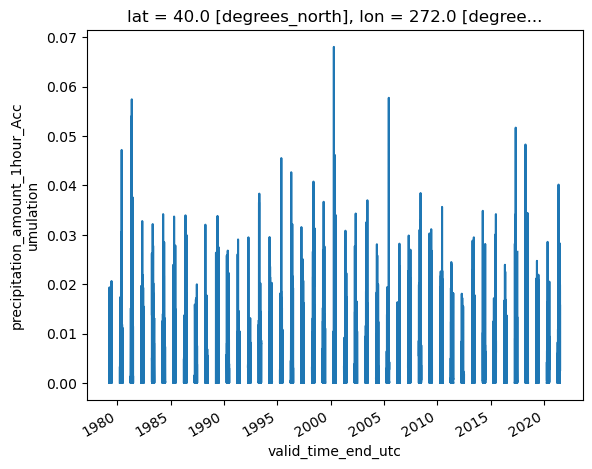

In [13]:
champaign_daily_wet.plot()

95th percentile is 18.7 cm/day in the model

In [15]:
champaign_daily_wet.quantile(.95)

<xarray.DataArray 'precipitation_amount_1hour_Accumulation' ()>
array(0.01870117)
Coordinates:
    quantile  float64 0.95

create a dataset containing the extreme values and dates that we will use to index the other variables 

In [20]:
champaign_daily_wet

<xarray.Dataset>
Dimensions:                                  (valid_time_end_utc: 15432)
Coordinates:
  * valid_time_end_utc                       (valid_time_end_utc) datetime64[ns] ...
    lat                                      float32 ...
    lon                                      float32 ...
Data variables:
    precipitation_amount_1hour_Accumulation  (valid_time_end_utc) float32 0.0...

Here is one way to select the 95th percentile values through indexing with a boolean condition.  A bit of gymnastics to get the results into an ok form for doing the logical comparison 😤

In [71]:
champaign_extremes = champaign_daily_wet['precipitation_amount_1hour_Accumulation'][champaign_daily_wet['precipitation_amount_1hour_Accumulation'].values >= float(champaign_daily_wet['precipitation_amount_1hour_Accumulation'].quantile(.95).values)]

In [72]:
champaign_extremes

<xarray.DataArray 'precipitation_amount_1hour_Accumulation' (
                                                             valid_time_end_utc: 196)>
array([0.019348, 0.01886 , 0.02063 , 0.030579, 0.026611, 0.020508, 0.031799,
       0.04718 , 0.020081, 0.054077, 0.019775, 0.057434, 0.036438, 0.037598,
       0.03656 , 0.02771 , 0.022339, 0.019653, 0.032776, 0.020142, 0.021851,
       0.019287, 0.026245, 0.02063 , 0.021179, 0.032166, 0.029419, 0.025452,
       0.027771, 0.020203, 0.03418 , 0.021729, 0.028503, 0.023926, 0.033691,
       0.027832, 0.022278, 0.033936, 0.029968, 0.019958, 0.032043, 0.026367,
       0.021362, 0.023865, 0.033813, 0.026611, 0.027527, 0.025818, 0.021912,
       0.026794, 0.020081, 0.022217, 0.026062, 0.029053, 0.02948 , 0.024536,
       0.03656 , 0.03833 , 0.020203, 0.029541, 0.025024, 0.02356 , 0.021423,
       0.020264, 0.020508, 0.045532, 0.019043, 0.042664, 0.028442, 0.020081,
       0.023926, 0.032166, 0.018799, 0.021606, 0.019104, 0.019226, 0.031555,
       0.021057, 0.025024, 0.020691, 0.026611, 0.021484, 0.040771, 0.024963,
       0.026489, 0.022217, 0.031311, 0.019775, 0.026917, 0.023376, 0.024109,
       0.020508, 0.036682, 0.024292, 0.027649, 0.068054, 0.046143, 0.033997,
       0.018982, 0.030823, 0.018738, 0.021301, 0.022217, 0.02771 , 0.023499,
       0.034302, 0.030518, 0.024902, 0.02063 , 0.019531, 0.032532, 0.036987,
       0.02832 , 0.028076, 0.025818, 0.019958, 0.019409, 0.057739, 0.028198,
       0.023621, 0.022644, 0.029846, 0.026978, 0.02124 , 0.019897, 0.031006,
       0.020386, 0.032959, 0.031311, 0.038452, 0.024475, 0.019104, 0.023865,
       0.027222, 0.030273, 0.022827, 0.031128, 0.026794, 0.019348, 0.022583,
       0.021729, 0.035645, 0.022705, 0.020996, 0.019226, 0.024475, 0.023621,
       0.024048, 0.025208, 0.021423, 0.028809, 0.022949, 0.019348, 0.019714,
       0.02948 , 0.034851, 0.024048, 0.020386, 0.018738, 0.021545, 0.028137,
       0.030029, 0.03418 , 0.023926, 0.022522, 0.020203, 0.028198, 0.020813,
       0.02655 , 0.026062, 0.03418 , 0.051697, 0.02655 , 0.048279, 0.024353,
       0.033203, 0.033936, 0.034424, 0.022644, 0.022156, 0.021179, 0.020935,
       0.024719, 0.018799, 0.020935, 0.021912, 0.028564, 0.019653, 0.020508,
       0.038208, 0.040161, 0.031982, 0.024597, 0.028259, 0.019714, 0.019897],
      dtype=float32)
Coordinates:
  * valid_time_end_utc  (valid_time_end_utc) datetime64[ns] 1979-04-12 ... 20...
    lat                 float32 40.0
    lon                 float32 272.0

Save to a file so we can start from here!

In [73]:
import pandas as pd
#https://rda.ucar.edu/thredds/catalog/files/g/ds633.0/e5.oper.an.pl/196410/catalog.html

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.an.pl/'
base_url2 = '/e5.oper.an.pl.128_133_q.ll025sc.'
base_url3 = '.nc'
# period of interest - pd.date_range allos you pick range of data
pr = pd.to_datetime(champaign_extremes.valid_time_end_utc.values)

file_list = []
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    date_str = dt.strftime('%Y%m%d%H')
    date_str_2 = (dt + pd.DateOffset(hours=23)).strftime('%Y%m%d%H')        # build complete file name
    single_file=(base_url+year+month+base_url2+date_str+'_'+date_str_2+base_url3)
    file_list.append(single_file)
   


compute the values on the 95th percentile days

In [132]:
ds_tmp = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(level = 850.0).sel(latitude=slice(lat_cmi+20.,lat_cmi-20.,1),longitude=slice(360.+lon_cmi-20.,360.+lon_cmi+20.,1))


Select the 00Z time from the files

In [133]:
#Code for daily mean
#ds_00z = ds_tmp.chunk(chunks={'time': '100MB'})
#Code for mean only at hour == 00Z
ds_00z = ds_tmp.sel(time = ds_tmp['time'][ds_tmp['time'].dt.hour == 0]).chunk(chunks={'time': '100MB'})


Compute the mean of the 95th percentile days

In [134]:
ds_00z_mean = ds_00z.mean(dim='time').compute()

In [128]:
ds_00z_mean

<xarray.Dataset>
Dimensions:    (latitude: 160, longitude: 161)
Coordinates:
  * latitude   (latitude) float64 60.0 59.75 59.5 59.25 ... 20.75 20.5 20.25
    level      float64 850.0
  * longitude  (longitude) float64 252.0 252.2 252.5 252.8 ... 291.5 291.8 292.0
Data variables:
    utc_date   float64 2e+09
    Q          (latitude, longitude) float32 0.002695 0.00269 ... 0.009076

In [109]:
ds_00z_mean.to_netcdf('q_mean_amj.nc')

Now let's do the April-June climatology from 1979-2021

In [111]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.pl/'
base_url2 = '/e5.moda.an.pl.128_133_q.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    
    file_list.append(single_file)


Let's open the files, slicing for the pressure level, and geographic box

In [112]:
ds = xr.open_mfdataset(file_list, chunks={'time': '100MB'}).sel(level = 850.0).sel(latitude=slice(lat_cmi+20.,lat_cmi-20.,1),longitude=slice(360.+lon_cmi-20.,360.+lon_cmi+20.,1))

let's subset by month to get April - June

In [113]:
ds_amj = ds.sel(time = ds.time[(ds.time.dt.month >= 4) & (ds.time.dt.month <= 6)])

In [114]:
ds_mean_amj = ds_amj.mean(dim='time').compute()

In [115]:
ds_mean_amj

<xarray.Dataset>
Dimensions:    (latitude: 160, longitude: 161)
Coordinates:
  * latitude   (latitude) float64 60.0 59.75 59.5 59.25 ... 20.75 20.5 20.25
    level      float64 850.0
  * longitude  (longitude) float64 252.0 252.2 252.5 252.8 ... 291.5 291.8 292.0
Data variables:
    utc_date   float64 2e+09
    Q          (latitude, longitude) float32 0.003044 0.003039 ... 0.008972

In [116]:
ds_mean_amj.to_netcdf('q_ltmean_amj.nc')

Let's plot!

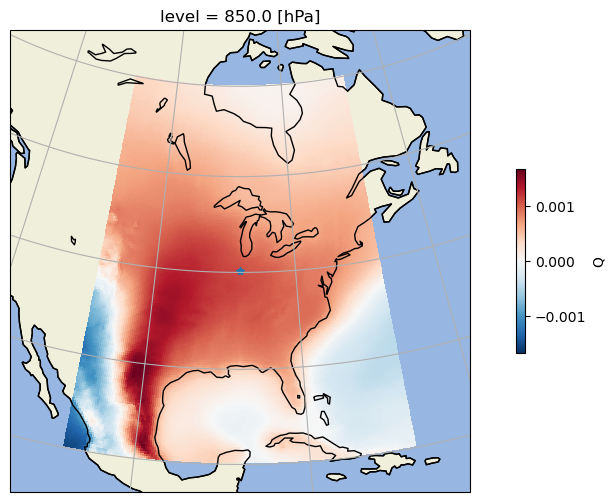

In [135]:
from turtle import fillcolor
import cartopy.crs as ccrs
import cartopy

central_lat = lat_cmi
central_lon = lon_cmi
extent = [central_lon-25., central_lon+25, central_lat-25, central_lat+25]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

(ds_mean_amj['Q']-ds_00z_mean['Q']).plot(ax=ax, transform=ccrs.PlateCarree(),
         cbar_kwargs={'shrink': 0.4})

ax.add_feature(cartopy.feature.COASTLINE, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')

plt.plot(lon_cmi, lat_cmi, "*", transform=ccrs.PlateCarree())
ax.gridlines()